# Imports

In [94]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Data Preprocessing

## Data Sources

Our data comes from the Federal Reserve Economic Data (FRED). We use in particular the change in the target value for the Federal Funds Rate (FFR). Here are some other examples of economic indicators for which we downloaded data.

**Michigan Inflation Expectation**

The Michigan Inflation Expectation dataset is a monthly time-series dataset that attempts to predict where the consumer price index will be a year from now.

https://fred.stlouisfed.org/series/MICH

**US CPI Rate**

https://fred.stlouisfed.org/series/CPALTT01USM657N

In [95]:
PATH_FFR_PRE_2008 = 'data/FFR_pre_2008.csv'
df_pre_2008 = pd.read_csv(PATH_FFR_PRE_2008, low_memory=False)

PATH_FFR_POST_2008 = 'data/FFR_post_2008.csv'
df_post_2008 = pd.read_csv(PATH_FFR_POST_2008, low_memory=False)

PATH_UNEMPLOYMENT = 'data/UNRATE.csv'
df_unemployment = pd.read_csv(PATH_UNEMPLOYMENT, low_memory=False)
df_unemployment['DATE'] = pd.to_datetime(df_unemployment['DATE'])
df_unemployment.columns = ['date', 'unemployment']

PATH_INFLATION = 'data/PCE_inflation.csv'
df_inflation = pd.read_csv(PATH_INFLATION, low_memory=False)
df_inflation['DATE'] = pd.to_datetime(df_inflation['DATE'])
df_inflation.columns = ['date', 'inflation']

PATH_EXPECTED_CPI = 'data/Michigan Inflation Expectation.csv'
df_expected_cpi = pd.read_csv(PATH_EXPECTED_CPI, low_memory=False)
df_expected_cpi['DATE'] = pd.to_datetime(df_expected_cpi['DATE'])
df_expected_cpi.columns = ['date', 'expected_cpi']

PATH_PCE = 'data/PCE.csv'
df_pce = pd.read_csv(PATH_PCE, low_memory=False)
df_pce['DATE'] = pd.to_datetime(df_pce['DATE'])
df_pce.columns = ['date', 'pce']

PATH_NETEX = 'data/NETEXC.csv'
df_netex_quarterly = pd.read_csv(PATH_NETEX, low_memory=False)
df_netex_quarterly['DATE'] = pd.to_datetime(df_netex_quarterly['DATE'])
df_netex_quarterly.columns = ['date', 'netex']
# make quarterly data monthly
dates = []
netex_values = []
for i in range(len(df_netex_quarterly)):
    dates.extend([df_netex_quarterly['date'].iloc[i] + pd.DateOffset(months=j) for j in range(3)])
    netex_values.extend([df_netex_quarterly['netex'].iloc[i]] * 3)
df_netex = pd.DataFrame({'date': dates, 'netex': netex_values})



In [96]:
# concatenate pre- and post-2008 FFR data, impute value for Dec 2008
df_pre_2008.columns = ['date', 'ffr']
df_dec_2008 = pd.DataFrame({'date':['2008-12-01'], 'ffr':[.250000]})
df_post_2008.columns = ['date', 'ffr']

df = pd.concat([df_pre_2008, df_dec_2008, df_post_2008], ignore_index=True)
df['date'] = pd.to_datetime(df['date'])
print('Number of NANs in dataframe:')
df.isna().sum()

Number of NANs in dataframe:


date    0
ffr     0
dtype: int64

In [97]:
print("FFR data")
display(df.head(5))

print("Unemployment data")
display(df_unemployment.head(5))

print("CPI data")
display(df_inflation.head(5))

print("Expected CPI data")
display(df_expected_cpi.head(5))

print("Net exports data")
display(df_netex)

FFR data


,date,ffr
0,1994-01-01,3.000000
1,1994-02-01,3.223214
2,1994-03-01,3.330645
3,1994-04-01,3.608333
4,1994-05-01,3.991935


Unemployment data


,date,unemployment
0,1994-01-01,6.6
1,1994-02-01,6.6
2,1994-03-01,6.5
3,1994-04-01,6.4
4,1994-05-01,6.1


CPI data


,date,inflation
0,1994-01-01,2.36
1,1994-02-01,2.35
2,1994-03-01,2.41
3,1994-04-01,2.30
4,1994-05-01,2.27


Expected CPI data


,date,expected_cpi
0,1978-01-01,5.2
1,1978-02-01,6.4
2,1978-03-01,6.3
3,1978-04-01,6.7
4,1978-05-01,6.9


Net exports data


,date,netex
0,1970-01-01,-58.811
1,1970-02-01,-58.811
2,1970-03-01,-58.811
3,1970-04-01,-56.426
4,1970-05-01,-56.426
...,...,...
652,2024-05-01,-1035.661
653,2024-06-01,-1035.661
654,2024-07-01,-1077.567
655,2024-08-01,-1077.567


In [98]:
df['ffr_1m_change'] = df['ffr'] - df['ffr'].shift(1)  # 1-month change
# df['ffr_3m_change'] = df['ffr'] - df['ffr'].shift(3)  # 3-month change
# df['ffr_6m_change'] = df['ffr'] - df['ffr'].shift(6)  # 6-month change
# df['ffr_12m_change'] = df['ffr'] - df['ffr'].shift(12)  # 12-month change
# df['ffr_24m_change'] = df['ffr'] - df['ffr'].shift(24)  # 24-month change

df = pd.merge(df, df_unemployment, on='date', how='inner')
df = pd.merge(df, df_inflation, on='date', how='inner')
df = pd.merge(df, df_expected_cpi, on='date', how='inner')
df = pd.merge(df, df_pce, on='date', how='inner')
df = pd.merge(df, df_netex, on='date', how='inner')

change_predictors = ['unemployment', 'inflation', 'expected_cpi', 'pce']
month_shifts = [1, 3, 6, 12, 24]
for predictor in change_predictors:
    for shift in month_shifts:
        df[predictor+f'_{shift}m_change'] = df[predictor] - df[predictor].shift(shift)


In [99]:
df['ffr_previous_change'] = df['ffr_1m_change'].shift(1)
df[['ffr_previous_change', 'ffr_1m_change']]

,ffr_previous_change,ffr_1m_change
0,NaN,NaN
1,NaN,0.223214
2,0.223214,0.107431
3,0.107431,0.277688
4,0.277688,0.383602
...,...,...
364,0.000000,0.000000
365,0.000000,0.000000
366,0.000000,0.000000
367,0.000000,0.000000


In [100]:
df.columns
df.dtypes

date                       datetime64[ns]
ffr                               float64
ffr_1m_change                     float64
unemployment                      float64
inflation                         float64
expected_cpi                      float64
pce                               float64
netex                             float64
unemployment_1m_change            float64
unemployment_3m_change            float64
unemployment_6m_change            float64
unemployment_12m_change           float64
unemployment_24m_change           float64
inflation_1m_change               float64
inflation_3m_change               float64
inflation_6m_change               float64
inflation_12m_change              float64
inflation_24m_change              float64
expected_cpi_1m_change            float64
expected_cpi_3m_change            float64
expected_cpi_6m_change            float64
expected_cpi_12m_change           float64
expected_cpi_24m_change           float64
pce_1m_change                     

# Summary of the Data

In [101]:
df.describe()

,date,ffr,ffr_1m_change,unemployment,inflation,expected_cpi,pce,netex,unemployment_1m_change,unemployment_3m_change,...,expected_cpi_3m_change,expected_cpi_6m_change,expected_cpi_12m_change,expected_cpi_24m_change,pce_1m_change,pce_3m_change,pce_6m_change,pce_12m_change,pce_24m_change,ffr_previous_change
count,369,369.000000,368.000000,369.000000,369.000000,369.000000,369.000000,369.000000,368.000000,366.000000,...,366.000000,363.000000,357.000000,345.000000,368.000000,366.000000,363.000000,357.000000,345.000000,367.000000
mean,2009-05-01 16:00:00,2.605512,0.006250,5.596206,2.169051,3.049593,10442.041463,-492.927114,-0.006793,-0.019399,...,-0.000546,0.001377,0.007003,0.044638,41.954348,125.524317,250.524793,498.563025,988.763478,0.006812
min,1994-01-01 00:00:00,0.250000,-0.975806,3.400000,0.800000,0.400000,4585.100000,-1132.084000,-2.200000,-4.800000,...,-2.600000,-3.400000,-2.500000,-2.500000,-1576.100000,-2609.900000,-2383.000000,-2055.600000,-1604.000000,-0.975806
25%,2001-09-01 00:00:00,0.250000,0.000000,4.300000,1.730000,2.700000,7121.700000,-649.034000,-0.100000,-0.200000,...,-0.200000,-0.200000,-0.300000,-0.400000,18.675000,76.625000,154.550000,314.800000,642.900000,0.000000
50%,2009-05-01 00:00:00,1.891667,0.000000,5.100000,2.040000,2.900000,10035.300000,-479.531000,0.000000,-0.100000,...,0.000000,0.000000,0.000000,0.000000,36.800000,113.000000,215.700000,432.200000,853.000000,0.000000
75%,2017-01-01 00:00:00,5.250000,0.000000,6.100000,2.370000,3.200000,13005.900000,-328.833000,0.100000,0.100000,...,0.200000,0.250000,0.300000,0.400000,58.550000,154.875000,278.600000,526.100000,1030.700000,0.000000
max,2024-09-01 00:00:00,6.500000,0.700000,14.800000,4.990000,5.400000,20024.300000,-39.085000,10.400000,11.200000,...,1.700000,2.400000,2.300000,3.300000,1017.300000,2069.400000,2491.600000,3680.600000,5259.400000,0.700000
std,NaN,2.204385,0.178279,1.802546,0.732881,0.684380,3984.583035,263.034716,0.596568,1.007686,...,0.519799,0.666212,0.768613,0.955085,135.081039,245.487647,315.489780,471.779327,727.529503,0.178196


## Visualizations

We made some visualizations to get a sense of some of the economic trends and their interactions with the FFR.

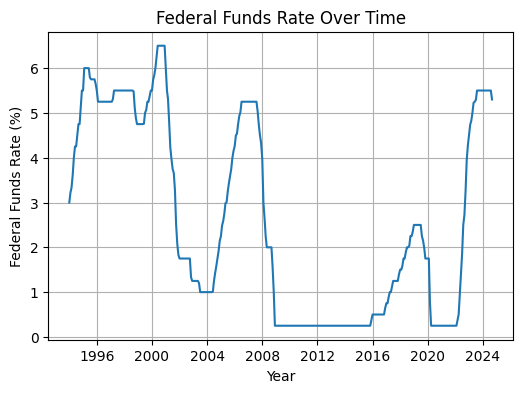

In [102]:
plt.figure(figsize=(6, 4))
plt.plot(df.date, df.ffr)
plt.title('Federal Funds Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Federal Funds Rate (%)')
plt.grid()
plt.show()

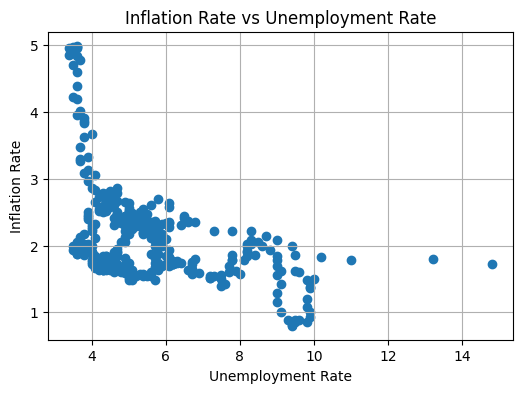

In [103]:
plt.figure(figsize=(6, 4))
plt.scatter(df.unemployment, df.inflation)
plt.title('Inflation Rate vs Unemployment Rate')
plt.xlabel('Unemployment Rate')
plt.ylabel('Inflation Rate')
plt.grid()
plt.show()

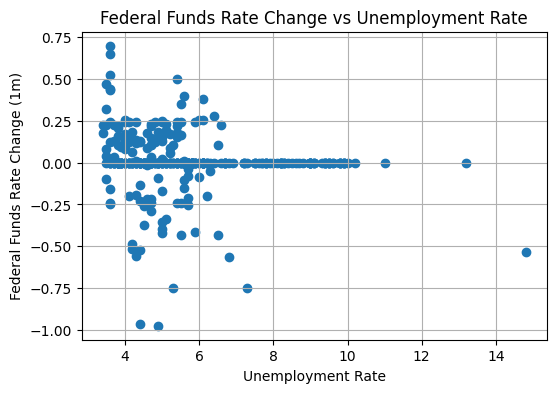

In [104]:
plt.figure(figsize=(6, 4))
plt.scatter(df.unemployment, df.ffr_1m_change)
plt.title('Federal Funds Rate Change vs Unemployment Rate')
plt.xlabel('Unemployment Rate')
plt.ylabel('Federal Funds Rate Change (1m)')
plt.grid()
plt.show()

In [105]:
date = pd.to_datetime('1994-01-01')
month = pd.DateOffset(months=1)
while date < pd.to_datetime('2024-10-01'):
    if date not in df['date'].values:
        print('missing: '+str(date))
    date += month

## Basic Linear Regression Model (example)

Now we fit a basic linear regression model to observe how well the current set of predictors can do at predicting the FFR change. We add a few interaction terms, but based on the analysis above we will want to be more careful moving forward to avoid overfitting. 

In [106]:
df = df.dropna()

X = df.drop(columns=['date', 'ffr_1m_change'])
X['unemployment_inflation'] = X['unemployment'] * X['inflation']
X['unemployment_expected_cpi'] = X['unemployment'] * X['expected_cpi']
X['inflation_expected_cpi'] = X['inflation'] * X['expected_cpi']
y = df['ffr_1m_change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("MSE:", mse)
print("R2 score:", r2)


Coefficients: [ 1.40272899e-02 -3.69949329e-02 -3.45442212e-01 -2.58188732e-01
  2.63294720e-06 -8.89193366e-05  3.98851408e-02 -1.83690463e-02
  4.01772887e-03 -1.51121949e-02 -2.90502039e-03  6.65662344e-02
 -3.34374380e-02 -4.60942780e-02  4.36657743e-02 -3.14290311e-03
  6.89277832e-02  9.01171752e-03  1.39321509e-02  8.75625950e-03
 -3.11903780e-03  2.50363360e-04 -6.90566888e-05  6.98048712e-07
 -4.58415780e-05  1.65410631e-05  5.92195666e-01  1.66827536e-02
  9.61038627e-03  7.60490524e-02]
Intercept: 0.7626127388932924
MSE: 0.025773549632727873
R2 score: 0.43682583921211493


In [107]:
X_train.columns

Index(['ffr', 'unemployment', 'inflation', 'expected_cpi', 'pce', 'netex',
       'unemployment_1m_change', 'unemployment_3m_change',
       'unemployment_6m_change', 'unemployment_12m_change',
       'unemployment_24m_change', 'inflation_1m_change', 'inflation_3m_change',
       'inflation_6m_change', 'inflation_12m_change', 'inflation_24m_change',
       'expected_cpi_1m_change', 'expected_cpi_3m_change',
       'expected_cpi_6m_change', 'expected_cpi_12m_change',
       'expected_cpi_24m_change', 'pce_1m_change', 'pce_3m_change',
       'pce_6m_change', 'pce_12m_change', 'pce_24m_change',
       'ffr_previous_change', 'unemployment_inflation',
       'unemployment_expected_cpi', 'inflation_expected_cpi'],
      dtype='object')

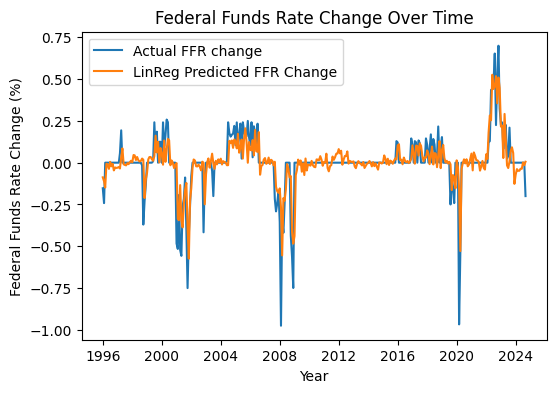

In [108]:
df.loc[:, 'predicted_ffr_change'] = model.predict(X)

plt.figure(figsize=(6, 4))
plt.plot(df.date, df.ffr_1m_change, label='Actual FFR change')
plt.plot(df.date, df.predicted_ffr_change, label='LinReg Predicted FFR Change')
plt.legend()
plt.title('Federal Funds Rate Change Over Time')
plt.xlabel('Year')
plt.ylabel('Federal Funds Rate Change (%)')
# plt.grid()
plt.show()